# TP1

In [1]:
from datetime import datetime, timedelta
import os
import time
import yfinance as yf
import pandas as pd
from tqdm import tqdm
companies = {
    "Apple": "AAPL",
    "Microsoft": "MSFT",
    "Amazon": "AMZN",
    "Alphabet": "GOOGL",
    "Meta": "META",
    "Tesla": "TSLA",
    "NVIDIA": "NVDA",
    "Samsung": "005930.KS",
    "Tencent": "TCEHY",
    "Alibaba": "BABA",
    "IBM": "IBM",
    "Intel": "INTC",
    "Oracle": "ORCL",
    "Sony": "SONY",
    "Adobe": "ADBE",
    "Netflix": "NFLX",
    "AMD": "AMD",
    "Qualcomm": "QCOM",
    "Cisco": "CSCO",
    "JP Morgan": "JPM",
    "Goldman Sachs": "GS",
    "Visa": "V",
    "Johnson & Johnson": "JNJ",
    "Pfizer": "PFE",
    "ExxonMobil": "XOM",
    "ASML": "ASML.AS",
    "SAP": "SAP.DE",
    "Siemens": "SIE.DE",
    "Louis Vuitton (LVMH)": "MC.PA",
    "TotalEnergies": "TTE.PA",
    "Shell": "SHEL.L",
    "Baidu": "BIDU",
    "JD.com": "JD",
    "BYD": "BYDDY",
    "ICBC": "1398.HK",
    "Toyota": "TM",
    "SoftBank": "9984.T",
    "Nintendo": "NTDOY",
    "Hyundai": "HYMTF",
    "Reliance Industries": "RELIANCE.NS",
    "Tata Consultancy Services": "TCS.NS"
}

def safe_get_ticker_info(symbol, retries=1, delay=3):
    for attempt in range(retries):
        try:
            return yf.Ticker(symbol).info
        except Exception as e:
            if "Rate limited" in str(e):
                print(f"⏳ Rate limited pour {symbol}. Nouvelle tentative dans {delay} secondes...")
                time.sleep(delay)
                delay *= 2
            else:
                raise e
    raise Exception(f"❌ Échec après {retries} tentatives pour {symbol}")

def scrape_financial_ratios(output_path):
    print("▶ Scraping des ratios financiers...")
    ratios = {
        "forwardPE": [], "beta": [], "priceToBook": [], "priceToSales": [],
        "dividendYield": [], "trailingEps": [], "debtToEquity": [],
        "currentRatio": [], "quickRatio": [], "returnOnEquity": [],
        "returnOnAssets": [], "operatingMargins": [], "profitMargins": []
    }

    company_names = []

    for company_name, symbol in tqdm(companies.items()):
        try:
            info = safe_get_ticker_info(symbol)
            company_names.append(company_name)
            for ratio_key in ratios.keys():
                value = info.get(ratio_key, None)
                ratios[ratio_key].append(value)
            time.sleep(1)
        except Exception as e:
            print(f"❌ Erreur pour {company_name}: {e}")
            for ratio_key in ratios:
                ratios[ratio_key].append(None)
            company_names.append(company_name)

    df_ratios = pd.DataFrame(ratios, index=company_names)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_ratios.to_csv(output_path, encoding='utf-8')
    print(f"✅ Ratios financiers sauvegardés dans {output_path}")

def fetch_stock_variations(company_name, symbol, start_date, end_date, output_folder):
    try:
        df = yf.download(symbol, start=start_date, end=end_date)
        df.columns = df.columns.droplevel(1)
        df.columns.name = None
        df.index.name = None
        df = df[["Close"]]
        df = df.reset_index()
        df.rename(columns={"index": "Date"}, inplace=True)

        if df.empty:
            raise ValueError("DataFrame vide – possible rate limit ou symbole invalide.")

        #df = df[['Close']].copy()

        #  Transforme l'index (Date) en colonne explicite

        # Conversion sécurisée de 'Close' en float
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
        df.dropna(subset=['Close'], inplace=True)

        df['Next_Day_Close'] = df['Close'].shift(-1)
        df['Daily_Return'] = df['Close'].pct_change()
        df.dropna(inplace=True)

        os.makedirs(output_folder, exist_ok=True)
        file_path = os.path.join(output_folder, f"{company_name.replace(' ', '_')}.csv")
        df.to_csv(file_path)
        time.sleep(1)
        return True, company_name, file_path
    except Exception as e:
        return False, company_name, str(e)

def main():
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    project_path = os.path.join(desktop, "Projet_Final_DS")
    os.makedirs(project_path, exist_ok=True)

    start_date = (datetime.today() - timedelta(days=365*5)).strftime("%Y-%m-%d")
    end_date = datetime.today().strftime("%Y-%m-%d")
    output_folder = os.path.join(project_path, "data", "companies")
    ratios_path = os.path.join(project_path, "data", "ratios.csv")

    # Partie 1 : Ratios financiers
    scrape_financial_ratios(ratios_path)

    # Partie 2 : Variations journalières
    success_count = 0
    failed_companies = []

    print("▶ Début du scraping des variations boursières...")
    for company_name, symbol in companies.items():
        success, name, result = fetch_stock_variations(company_name, symbol, start_date, end_date, output_folder)
        if success:
            success_count += 1
            print(f"✅ Données exportées pour {name} -> {result}")
        else:
            print(f"❌ Erreur pour {name} : {result}")
            failed_companies.append(name)

    print("\n📢 *Récapitulatif final*")
    print(f"✅ Nombre de fichiers exportés avec succès : {success_count}/{len(companies)}")

    if failed_companies:
        print("\n❗ Entreprises non récupérées :")
        for failed in failed_companies:
            print(f"  - {failed}")
    else:
        print("\n🎉 Toutes les entreprises ont été récupérées avec succès !")
#
main()

▶ Scraping des ratios financiers...


100%|██████████| 41/41 [00:49<00:00,  1.20s/it]


✅ Ratios financiers sauvegardés dans /root/Desktop/Projet_Final_DS/data/ratios.csv
▶ Début du scraping des variations boursières...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Apple -> /root/Desktop/Projet_Final_DS/data/companies/Apple.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Microsoft -> /root/Desktop/Projet_Final_DS/data/companies/Microsoft.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Amazon -> /root/Desktop/Projet_Final_DS/data/companies/Amazon.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Alphabet -> /root/Desktop/Projet_Final_DS/data/companies/Alphabet.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Meta -> /root/Desktop/Projet_Final_DS/data/companies/Meta.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Tesla -> /root/Desktop/Projet_Final_DS/data/companies/Tesla.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour NVIDIA -> /root/Desktop/Projet_Final_DS/data/companies/NVIDIA.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Samsung -> /root/Desktop/Projet_Final_DS/data/companies/Samsung.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Tencent -> /root/Desktop/Projet_Final_DS/data/companies/Tencent.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Alibaba -> /root/Desktop/Projet_Final_DS/data/companies/Alibaba.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour IBM -> /root/Desktop/Projet_Final_DS/data/companies/IBM.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Intel -> /root/Desktop/Projet_Final_DS/data/companies/Intel.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Oracle -> /root/Desktop/Projet_Final_DS/data/companies/Oracle.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Sony -> /root/Desktop/Projet_Final_DS/data/companies/Sony.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✅ Données exportées pour Adobe -> /root/Desktop/Projet_Final_DS/data/companies/Adobe.csv


✅ Données exportées pour Netflix -> /root/Desktop/Projet_Final_DS/data/companies/Netflix.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour AMD -> /root/Desktop/Projet_Final_DS/data/companies/AMD.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Qualcomm -> /root/Desktop/Projet_Final_DS/data/companies/Qualcomm.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Cisco -> /root/Desktop/Projet_Final_DS/data/companies/Cisco.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour JP Morgan -> /root/Desktop/Projet_Final_DS/data/companies/JP_Morgan.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Goldman Sachs -> /root/Desktop/Projet_Final_DS/data/companies/Goldman_Sachs.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Visa -> /root/Desktop/Projet_Final_DS/data/companies/Visa.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Johnson & Johnson -> /root/Desktop/Projet_Final_DS/data/companies/Johnson_&_Johnson.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Pfizer -> /root/Desktop/Projet_Final_DS/data/companies/Pfizer.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour ExxonMobil -> /root/Desktop/Projet_Final_DS/data/companies/ExxonMobil.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour ASML -> /root/Desktop/Projet_Final_DS/data/companies/ASML.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour SAP -> /root/Desktop/Projet_Final_DS/data/companies/SAP.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Siemens -> /root/Desktop/Projet_Final_DS/data/companies/Siemens.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Louis Vuitton (LVMH) -> /root/Desktop/Projet_Final_DS/data/companies/Louis_Vuitton_(LVMH).csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour TotalEnergies -> /root/Desktop/Projet_Final_DS/data/companies/TotalEnergies.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Shell -> /root/Desktop/Projet_Final_DS/data/companies/Shell.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Baidu -> /root/Desktop/Projet_Final_DS/data/companies/Baidu.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour JD.com -> /root/Desktop/Projet_Final_DS/data/companies/JD.com.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour BYD -> /root/Desktop/Projet_Final_DS/data/companies/BYD.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour ICBC -> /root/Desktop/Projet_Final_DS/data/companies/ICBC.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Toyota -> /root/Desktop/Projet_Final_DS/data/companies/Toyota.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour SoftBank -> /root/Desktop/Projet_Final_DS/data/companies/SoftBank.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Nintendo -> /root/Desktop/Projet_Final_DS/data/companies/Nintendo.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Hyundai -> /root/Desktop/Projet_Final_DS/data/companies/Hyundai.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Reliance Industries -> /root/Desktop/Projet_Final_DS/data/companies/Reliance_Industries.csv


[*********************100%***********************]  1 of 1 completed


✅ Données exportées pour Tata Consultancy Services -> /root/Desktop/Projet_Final_DS/data/companies/Tata_Consultancy_Services.csv

📢 *Récapitulatif final*
✅ Nombre de fichiers exportés avec succès : 41/41

🎉 Toutes les entreprises ont été récupérées avec succès !


# TP2

In [2]:
import json

with open("json_files/AMD_news.json" ) as file:
    data = json.load(file)

In [3]:
! pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [4]:
! ls /root/Desktop/Projet_Final_DS/data/companies/

 Adobe.csv	     ICBC.csv			 Reliance_Industries.csv
 Alibaba.csv	     Intel.csv			 Samsung.csv
 Alphabet.csv	     JD.com.csv			 SAP.csv
 Amazon.csv	    'Johnson_&_Johnson.csv'	 Shell.csv
 AMD.csv	     JP_Morgan.csv		 Siemens.csv
 Apple.csv	    'Louis_Vuitton_(LVMH).csv'	 SoftBank.csv
 ASML.csv	     Meta.csv			 Sony.csv
 Baidu.csv	     Microsoft.csv		 Tata_Consultancy_Services.csv
 BYD.csv	     Netflix.csv		 Tencent.csv
 Cisco.csv	     Nintendo.csv		 Tesla.csv
 ExxonMobil.csv      NVIDIA.csv			 TotalEnergies.csv
 Goldman_Sachs.csv   Oracle.csv			 Toyota.csv
 Hyundai.csv	     Pfizer.csv			 Visa.csv
 IBM.csv	     Qualcomm.csv


In [5]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

def preprocess_for_financial_clustering(filepath, selected_columns):
    df = pd.read_csv(filepath, index_col=0)
    df_clean = df[selected_columns].dropna()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_clean)
    return pd.DataFrame(data_scaled, index=df_clean.index, columns=df_clean.columns), df_clean

def prepare_daily_returns(folder_path):
    all_returns = {}
    for filepath in glob.glob(os.path.join(folder_path, "*.csv")):
        company = os.path.basename(filepath).replace(".csv", "").replace("_", " ")
        df = pd.read_csv(filepath)
        if "Daily_Return" in df.columns:
            all_returns[company] = df["Daily_Return"]
    df_returns = pd.DataFrame(all_returns).fillna(method='ffill').fillna(method='bfill')
    return df_returns.corr()

def do_kmeans(data, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(data)
    return labels, silhouette_score(data, labels)

def do_hierarchical(data, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(data)
    return labels, silhouette_score(data, labels)

def do_dbscan(data, eps=1, min_samples=2):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(data)
    try:
        score = silhouette_score(data, labels) if len(set(labels)) > 1 else -1
    except:
        score = -1
    return labels, score

def save_labels_with_data(df_data, labels_dict, dataset_name, output_path):
    df_out = df_data.copy()
    for algo, labels in labels_dict.items():
        df_out[algo + "_Cluster"] = labels
    filename = dataset_name.lower().replace(" ", "_") + "_labels.csv"
    full_path = os.path.join(output_path, filename)
    df_out.to_csv(full_path)
    print(f"✅ Données + labels sauvegardés : {full_path}")

def plot_tsne(data_scaled, labels_dict, dataset_name, output_path):
    tsne = TSNE(n_components=2, random_state=42, init="random", perplexity=5)
    tsne_results = tsne.fit_transform(data_scaled)

    for algo, clusters in labels_dict.items():
        df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
        df_tsne["Cluster"] = clusters

        plt.figure(figsize=(8, 6))
        unique_clusters = np.unique(clusters)
        colors = plt.colormaps.get_cmap("tab10")

        for i, cluster in enumerate(unique_clusters):
            subset = df_tsne[df_tsne["Cluster"] == cluster]
            plt.scatter(subset["TSNE1"], subset["TSNE2"],
                        label=f"Cluster {cluster}",
                        color=colors(i % 10),
                        alpha=0.7)

        plt.xlabel("TSNE 1")
        plt.ylabel("TSNE 2")
        plt.title(f"TSNE - {dataset_name} - {algo}")
        plt.legend()
        filename = f"{dataset_name.lower().replace(' ', '_')}_{algo.lower()}_tsne.png"
        plt.savefig(os.path.join(output_path, filename))
        plt.close()
        print(f"📸 TSNE sauvegardé : {filename}")

def main():
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    project_path = os.path.join(desktop, "Projet_Final_DS")
    ratios_path = os.path.join(project_path, "data", "ratios.csv")
    returns_folder = os.path.join(project_path, "data", "companies")
    output_path = os.path.join(project_path, "outputs", "clustering")
    os.makedirs(output_path, exist_ok=True)

    selected_columns_finance = ["forwardPE", "beta", "priceToBook", "returnOnEquity"]
    selected_columns_risk = ["debtToEquity", "currentRatio", "quickRatio"]

    data_finance_scaled, data_finance_raw = preprocess_for_financial_clustering(ratios_path, selected_columns_finance)
    data_risk_scaled, data_risk_raw = preprocess_for_financial_clustering(ratios_path, selected_columns_risk)
    data_returns = prepare_daily_returns(returns_folder)
    data_returns_dist = 1 - data_returns

    datasets = {
        "Financial Profile": (data_finance_scaled, data_finance_raw),
        "Risk Profile": (data_risk_scaled, data_risk_raw),
        "Daily Returns Correlation": (data_returns_dist, data_returns)
    }

    results = []

    for name, (data_scaled, data_original) in datasets.items():
        print(f"\n📊 Résultats pour : {name}")
        try:
            labels_km, score_km = do_kmeans(data_scaled, n_clusters=5)
            labels_hc, score_hc = do_hierarchical(data_scaled, n_clusters=5)
            labels_db, score_db = do_dbscan(data_scaled, eps=1, min_samples=2)

            all_scores = {
                "KMeans": score_km,
                "Hierarchical": score_hc,
                "DBSCAN": score_db
            }
            best_algo = max(all_scores, key=all_scores.get)

            print(f"KMeans Silhouette Score      : {score_km:.3f}")
            print(f"Hierarchical Silhouette Score: {score_hc:.3f}")
            print(f"DBSCAN Silhouette Score      : {score_db:.3f}")
            print(f"✅ Meilleur algo : {best_algo}")

            results.append({
                "Dataset": name,
                "KMeans Silhouette": score_km,
                "Hierarchical Silhouette": score_hc,
                "DBSCAN Silhouette": score_db,
                "Best Algorithm": best_algo
            })

            labels_dict = {
                "KMeans": labels_km,
                "Hierarchical": labels_hc,
                "DBSCAN": labels_db
            }

            save_labels_with_data(data_original, labels_dict, name, output_path)
            plot_tsne(data_scaled, labels_dict, name, output_path)

        except Exception as e:
            print(f"❌ Erreur sur {name} : {e}")
            results.append({
                "Dataset": name,
                "KMeans Silhouette": None,
                "Hierarchical Silhouette": None,
                "DBSCAN Silhouette": None,
                "Best Algorithm": f"Erreur: {e}"
            })

    results_df = pd.DataFrame(results)
    results_csv_path = os.path.join(output_path, "clustering_results.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"📄 Résumé des scores sauvegardé dans : {results_csv_path}")


main()


<ipython-input-5-1a4e88e0a15d>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_returns = pd.DataFrame(all_returns).fillna(method='ffill').fillna(method='bfill')



📊 Résultats pour : Financial Profile
KMeans Silhouette Score      : 0.359
Hierarchical Silhouette Score: 0.367
DBSCAN Silhouette Score      : 0.436
✅ Meilleur algo : DBSCAN
✅ Données + labels sauvegardés : /root/Desktop/Projet_Final_DS/outputs/clustering/financial_profile_labels.csv
📸 TSNE sauvegardé : financial_profile_kmeans_tsne.png
📸 TSNE sauvegardé : financial_profile_hierarchical_tsne.png
📸 TSNE sauvegardé : financial_profile_dbscan_tsne.png

📊 Résultats pour : Risk Profile
KMeans Silhouette Score      : 0.526
Hierarchical Silhouette Score: 0.571
DBSCAN Silhouette Score      : 0.767
✅ Meilleur algo : DBSCAN
✅ Données + labels sauvegardés : /root/Desktop/Projet_Final_DS/outputs/clustering/risk_profile_labels.csv
📸 TSNE sauvegardé : risk_profile_kmeans_tsne.png
📸 TSNE sauvegardé : risk_profile_hierarchical_tsne.png
📸 TSNE sauvegardé : risk_profile_dbscan_tsne.png

📊 Résultats pour : Daily Returns Correlation
KMeans Silhouette Score      : 0.261
Hierarchical Silhouette Score: 0.286

/usr/local/lib/python3.11/dist-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


📸 TSNE sauvegardé : daily_returns_correlation_kmeans_tsne.png
📸 TSNE sauvegardé : daily_returns_correlation_hierarchical_tsne.png
📸 TSNE sauvegardé : daily_returns_correlation_dbscan_tsne.png
📄 Résumé des scores sauvegardé dans : /root/Desktop/Projet_Final_DS/outputs/clustering/clustering_results.csv


# TP 3

In [6]:
! pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4a83198c94183d5b2f1391edb619d7d37f425a65554cef39d0745fd106a0ac4d
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [7]:
!pip install xgboost


Training XGBoost...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END learning_rate=0.01, n_estimators=10;, score=0.537 total time=   1.0s
[CV 2/2] END learning_rate=0.01, n_estimators=10;, score=0.544 total time=   1.8s
[CV 1/2] END learning_rate=0.01, n_estimators=40;, score=0.555 total time=   5.2s
[CV 2/2] END learning_rate=0.01, n_estimators=40;, score=0.557 total time=   4.2s
[CV 1/2] END learning_rate=0.1, n_estimators=10;, score=0.562 total time=   1.6s
[CV 2/2] END learning_rate=0.1, n_estimators=10;, score=0.577 total time=   0.7s
[CV 1/2] END learning_rate=0.1, n_estimators=40;, score=0.605 total time=   3.8s
[CV 2/2] END learning_rate=0.1, n_estimators=40;, score=0.615 total time=   1.1s
              precision    recall  f1-score   support

           0       0.73      0.36      0.48       994
           1       0.59      0.89      0.71      2359
           2       0.71      0.38      0.50      1443

    accuracy                           0.62      47

<Figure size 640x480 with 0 Axes>

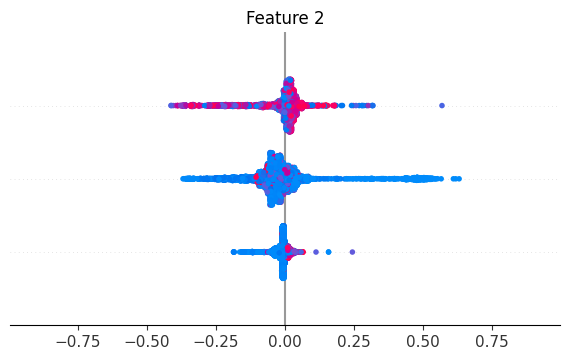

Training KNN...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2] END .....................n_neighbors=3;, score=0.488 total time=   1.5s
[CV 2/2] END .....................n_neighbors=3;, score=0.478 total time=   1.6s
[CV 1/2] END .....................n_neighbors=5;, score=0.493 total time=   1.8s
[CV 2/2] END .....................n_neighbors=5;, score=0.495 total time=   0.9s
              precision    recall  f1-score   support

           0       0.39      0.42      0.40       994
           1       0.57      0.69      0.62      2359
           2       0.51      0.31      0.39      1443

    accuracy                           0.52      4796
   macro avg       0.49      0.47      0.47      4796
weighted avg       0.51      0.52      0.51      4796

Accuracy: 0.52
SHAP summary plot not available for KNeighborsClassifier model.
Training SVM...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ..............C=0.1, kernel=linear;, score=0.489 tota

In [ ]:

#!pip install ta
#!pip install shap
#
#!pip install xgboost

import pandas as pd
import glob
import ta
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import shap
import matplotlib.pyplot as plt

def load_and_prepare_data(folder_path):
    files = glob.glob(f"{folder_path}/*.csv")[:20]
    dataframes = []

    for file in files:
        df = pd.read_csv(file)
        df['Close Horizon'] = df['Close'].shift(-20)
        df['Horizon Return'] = (df['Close Horizon'] - df['Close']) / df['Close']
        df['Label'] = df['Horizon Return'].apply(lambda x: 2 if x > 0.05 else (0 if x < -0.05 else 1))

        df['SMA 20'] = ta.trend.sma_indicator(df['Close'], window=20)
        df['EMA 20'] = ta.trend.ema_indicator(df['Close'], window=20)
        df['RSI 14'] = ta.momentum.rsi(df['Close'], window=14)
        df['MACD'] = ta.trend.macd(df['Close'])
        df['MACD Signal'] = ta.trend.macd_signal(df['Close'])
        df['Bollinger High'] = ta.volatility.bollinger_hband(df['Close'])
        df['Bollinger Low'] = ta.volatility.bollinger_lband(df['Close'])
        df['Rolling Volatility 20'] = df['Close'].rolling(window=20).std()
        df['ROC 10'] = ta.momentum.roc(df['Close'], window=10)

        df.dropna(inplace=True)
        dataframes.append(df)

    full_data = pd.concat(dataframes, ignore_index=True)
    return full_data

def preprocess_data(df):
    X = df.drop(columns=['Label', 'Close Horizon', 'Horizon Return'])
    Y = df['Label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

def train_and_evaluate_model(model, param_grid, X_train, X_test, Y_train, Y_test):
    grid_search = GridSearchCV(model, param_grid, cv=2, scoring='accuracy', verbose = 3 )
    grid_search.fit(X_train, Y_train)
    best_model = grid_search.best_estimator_

    Y_pred = best_model.predict(X_test)
    print(classification_report(Y_test, Y_pred))
    print(f"Accuracy: {accuracy_score(Y_test, Y_pred):.2f}")

    # Check if the model is tree-based before using TreeExplainer
    if isinstance(best_model, (RandomForestClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test)

        #shap.summary_plot(X_test,  shap_values)
        shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=3) # Changed to handle both single and multi-output models
    else:
        print(f"SHAP summary plot not available for {type(best_model).__name__} model.")

    return best_model

def main():
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    project_path = os.path.join(desktop, "Projet_Final_DS")
    folder_path = os.path.join(project_path, "data", "companies")
    df = load_and_prepare_data(folder_path)
    df = df.drop(columns=["Date"])
    X_train, X_test, Y_train, Y_test = preprocess_data(df)

    models = {
        "XGBoost": (XGBClassifier(), {'n_estimators': [10, 40], 'learning_rate': [0.01, 0.1]}),
        "KNN": (KNeighborsClassifier(), {'n_neighbors': [3, 5]}),
        "SVM": (SVC(), {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}),
        "LogisticRegression": (LogisticRegression(), {'C': [0.1, 1]}),
                "RandomForest": (RandomForestClassifier(), {'n_estimators': [10, 50, 100]}),

    }

    results = {}
    for name, (model, params) in models.items():
        print(f"Training {name}...")
        results[name] = train_and_evaluate_model(model, params, X_train, X_test, Y_train, Y_test)


main()



# TP4

In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

##############################################################################
# 1) Dictionnaire des meilleurs hyperparamètres par entreprise
##############################################################################
best_params = {
    "Tesla": {
        "XGBoost": {
            'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 3,
            'min_child_weight': 3,
            'n_estimators': 100,
            'subsample': 0.8,
            'objective': 'reg:squarederror',
            'seed': 42
        },
        "RandomForest": {
            'max_depth': 5,
            'min_samples_leaf': 2,
            'min_samples_split': 5,
            'n_estimators': 50,
            'random_state': 42
        },
        "KNN": {
            'n_neighbors': 9,
            'p': 1,
            'weights': 'uniform'
        }
    },
    "Samsung": {
        "XGBoost": {
            'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 3,
            'min_child_weight': 1,
            'n_estimators': 100,
            'subsample': 1.0,
            'objective': 'reg:squarederror',
            'seed': 42
        },
        "RandomForest": {
            'max_depth': 5,
            'min_samples_leaf': 1,
            'min_samples_split': 5,
            'n_estimators': 50,
            'random_state': 42
        },
        "KNN": {
            'n_neighbors': 3,
            'p': 2,
            'weights': 'distance'
        }
    },
    "Tencent": {
        "XGBoost": {
            'colsample_bytree': 0.8,
            'learning_rate': 0.1,
            'max_depth': 3,
            'min_child_weight': 1,
            'n_estimators': 100,
            'subsample': 1.0,
            'objective': 'reg:squarederror',
            'seed': 42
        },
        "RandomForest": {
            'max_depth': 10,
            'min_samples_leaf': 2,
            'min_samples_split': 2,
            'n_estimators': 50,
            'random_state': 42
        },
        "KNN": {
            'n_neighbors': 9,
            'p': 2,
            'weights': 'uniform'
        }
    },
    "Alibaba": {
        "XGBoost": {
            'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 7,
            'min_child_weight': 3,
            'n_estimators': 200,
            'subsample': 1.0,
            'objective': 'reg:squarederror',
            'seed': 42
        },
        "RandomForest": {
            'max_depth': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2,
            'n_estimators': 200,
            'random_state': 42
        },
        "KNN": {
            'n_neighbors': 3,
            'p': 2,
            'weights': 'distance'
        }
    },
    "Sony": {
        "XGBoost": {
            'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 3,
            'min_child_weight': 3,
            'n_estimators': 50,
            'subsample': 0.8,
            'objective': 'reg:squarederror',
            'seed': 42
        },
        "RandomForest": {
            'max_depth': 3,
            'min_samples_leaf': 1,
            'min_samples_split': 2,
            'n_estimators': 50,
            'random_state': 42
        },
        "KNN": {
            'n_neighbors': 9,
            'p': 2,
            'weights': 'uniform'
        }
    },
    "Adobe": {
        "XGBoost": {
            'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 3,
            'min_child_weight': 3,
            'n_estimators': 50,
            'subsample': 1.0,
            'objective': 'reg:squarederror',
            'seed': 42
        },
        "RandomForest": {
            'max_depth': 5,
            'min_samples_leaf': 2,
            'min_samples_split': 5,
            'n_estimators': 50,
            'random_state': 42
        },
        "KNN": {
            'n_neighbors': 9,
            'p': 2,
            'weights': 'distance'
        }
    },
    "Johnson & Johnson": {
        "XGBoost": {
            'colsample_bytree': 0.8,
            'learning_rate': 0.1,
            'max_depth': 3,
            'min_child_weight': 3,
            'n_estimators': 100,
            'subsample': 1.0,
            'objective': 'reg:squarederror',
            'seed': 42
        },
        "RandomForest": {
            'max_depth': 5,
            'min_samples_leaf': 2,
            'min_samples_split': 2,
            'n_estimators': 100,
            'random_state': 42
        },
        "KNN": {
            'n_neighbors': 9,
            'p': 2,
            'weights': 'uniform'
        }
    },
    "Pfizer": {
        "XGBoost": {
            'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 3,
            'min_child_weight': 1,
            'n_estimators': 100,
            'subsample': 1.0,
            'objective': 'reg:squarederror',
            'seed': 42
        },
        "RandomForest": {
            'max_depth': None,
            'min_samples_leaf': 2,
            'min_samples_split': 5,
            'n_estimators': 100,
            'random_state': 42
        },
        "KNN": {
            'n_neighbors': 7,
            'p': 2,
            'weights': 'distance'
        }
    },
    "Louis Vuitton (LVMH)": {
        "XGBoost": {
            'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 3,
            'min_child_weight': 3,
            'n_estimators': 100,
            'subsample': 1.0,
            'objective': 'reg:squarederror',
            'seed': 42
        },
        "RandomForest": {
            'max_depth': 5,
            'min_samples_leaf': 2,
            'min_samples_split': 5,
            'n_estimators': 100,
            'random_state': 42
        },
        "KNN": {
            'n_neighbors': 9,
            'p': 2,
            'weights': 'uniform'
        }
    }
}

##############################################################################
# 2) Fonctions utilitaires : Chargement, préparation des features
##############################################################################
def load_close_data(file_path):
    """Charge un CSV contenant au moins la colonne 'Close'.
       Trie par date si la colonne 'Date' existe.
       Retourne un DataFrame avec index=Date (si dispo) et colonne 'Close'.
    """
    df = pd.read_csv(file_path)

    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').set_index('Date')

    if 'Close' not in df.columns:
        raise ValueError(f"Le fichier {file_path} ne contient pas la colonne 'Close'.")

    return df[['Close']]

def create_target_features(df, n=30):
    """Reçoit un array df de shape (m,1).
       Retourne X, Y avec une fenêtre glissante de n=30.
    """
    x, y = [], []
    for i in range(n, df.shape[0]):
        x.append(df[i-n:i, 0])
        y.append(df[i, 0])
    return np.array(x), np.array(y)

def prepare_data_for_regression(file_path, n_days=30, test_ratio=0.2):
    """1) Charge le CSV, récupère 'Close'
       2) MinMaxScaler
       3) Crée X, Y avec create_target_features
       4) Split train/test (split temporel)
       5) Retourne X_train, Y_train, X_test, Y_test, scaler, close_vals
    """
    df_close = load_close_data(file_path)
    close_vals = df_close.values  # shape (m,1)

    scaler = MinMaxScaler(feature_range=(0,1))
    close_scaled = scaler.fit_transform(close_vals)

    X, Y = create_target_features(close_scaled, n=n_days)

    split_index = int((1 - test_ratio) * len(X))
    X_train, Y_train = X[:split_index], Y[:split_index]
    X_test,  Y_test  = X[split_index:], Y[split_index:]

    return X_train, Y_train, X_test, Y_test, scaler, close_vals

##############################################################################
# 3) Fonctions de régression (avec best params) + régression linéaire simple
##############################################################################
def build_xgb(params):
    """Construit un XGBRegressor avec les paramètres donnés."""
    return XGBRegressor(**params)

def build_rf(params):
    """Construit un RandomForestRegressor avec les paramètres donnés."""
    return RandomForestRegressor(**params)

def build_knn(params):
    """Construit un KNeighborsRegressor avec les paramètres donnés."""
    return KNeighborsRegressor(**params)

def build_linear():
    """Régression linéaire, sans hyperparamètres."""
    return LinearRegression()

def train_and_predict(model, X_train, Y_train, X_test, Y_test):
    """Entraîne le modèle et renvoie (pred, mse, rmse) sur X_test, Y_test."""
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)

    mse  = mean_squared_error(Y_test, pred)
    rmse = np.sqrt(mse)
    return pred, mse, rmse

##############################################################################
# 4) Pipeline : pour une entreprise, on charge, on entraîne, on affiche
##############################################################################
def run_for_company(company_name, file_path, n_days=30):
    """Charge les données, entraîne XGB, RF, KNN (avec best params),
       plus LinearRegression, calcule MSE/RMSE, et affiche la courbe.
    """
    # Récupération des hyperparamètres depuis le dictionnaire
    params_xgb = best_params[company_name]["XGBoost"]
    params_rf  = best_params[company_name]["RandomForest"]
    params_knn = best_params[company_name]["KNN"]

    X_train, Y_train, X_test, Y_test, scaler, close_vals = \
        prepare_data_for_regression(file_path, n_days=n_days, test_ratio=0.2)

    # Construction des 4 modèles
    model_xgb = build_xgb(params_xgb)
    model_rf  = build_rf(params_rf)
    model_knn = build_knn(params_knn)
    model_lr  = build_linear()

    # Entraînement et prédictions (sur l'échelle normalisée)
    preds_scaled = {}

    preds_scaled["XGBoost"], mse_xgb, rmse_xgb = train_and_predict(model_xgb, X_train, Y_train, X_test, Y_test)
    preds_scaled["RandomForest"], mse_rf, rmse_rf = train_and_predict(model_rf, X_train, Y_train, X_test, Y_test)
    preds_scaled["KNN"], mse_knn, rmse_knn = train_and_predict(model_knn, X_train, Y_train, X_test, Y_test)
    preds_scaled["Linear"], mse_lr, rmse_lr = train_and_predict(model_lr, X_train, Y_train, X_test, Y_test)

    # Inversion du scaling
    Y_test_true = scaler.inverse_transform(Y_test.reshape(-1,1)).ravel()

    results = []
    preds_true = {}

    for model_name, y_scaled in preds_scaled.items():
        y_true = scaler.inverse_transform(y_scaled.reshape(-1,1)).ravel()
        preds_true[model_name] = y_true

        # MSE/RMSE sur l'échelle inversée
        mse_inv = mean_squared_error(Y_test_true, y_true)
        rmse_inv = np.sqrt(mse_inv)

        # Récupération du MSE/RMSE normalisé (pour l'instant on les recalcule)
        mse_norm = mean_squared_error(Y_test, preds_scaled[model_name])
        rmse_norm = np.sqrt(mse_norm)

        results.append({
            "Model": model_name,
            "MSE_norm": mse_norm,
            "RMSE_norm": rmse_norm,
            "MSE_inversed": mse_inv,
            "RMSE_inversed": rmse_inv
        })

    df_res = pd.DataFrame(results)

    # Plot
    real_values = close_vals.ravel()
    test_start_index = len(close_vals) - len(Y_test_true)
    x_axis_pred = range(test_start_index, test_start_index + len(Y_test_true))

    plt.figure(figsize=(12, 6))
    plt.plot(real_values, label="Vraies valeurs (Close)", color='black')
    for model_name, y_pred in preds_true.items():
        plt.plot(x_axis_pred, y_pred, label=f"{model_name} Pred")
    plt.title(f"Prédictions pour {company_name}")
    plt.xlabel("Index temporel")
    plt.ylabel("Prix de clôture")
    plt.legend()
    plt.show()

    print(f"\n=== Résultats pour {company_name} ===")
    print(df_res)
    return df_res

##############################################################################
# 5) Programme principal : on boucle sur la liste des entreprises
##############################################################################
##############################################################################
# 5) Programme principal : on boucle sur la liste des entreprises
##############################################################################
def main():
    companies = {
        "Tesla": "TSLA",
        "Samsung": "005930.KS",
        "Tencent": "TCEHY",
        "Alibaba": "BABA",
        "Sony": "SONY",
        "Adobe": "ADBE",
        "Johnson & Johnson": "JNJ",
        "Pfizer": "PFE",
        "Louis Vuitton (LVMH)": "MC.PA",
    }

    data_folder = "Companies historical data"  # Dossier où se trouvent les CSV
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    project_path = os.path.join(desktop, "Projet_Final_DS")
    data_folder = os.path.join(project_path, "data", "companies")

    all_results = [] # Initialize the list here

    for company_name, symbol in companies.items():
        # Nom de fichier (ex: "Tesla_historical_data.csv")

        csv_file = f"{company_name.replace(' ', '_')}.csv"
        file_path = os.path.join(data_folder, csv_file)


        if not os.path.exists(file_path):
            print(f"Fichier introuvable : {file_path}")
            continue

        print(f"\n--- {company_name} ({symbol}) ---")
        df_res = run_for_company(company_name, file_path, n_days=30)

        # Ajout de la colonne "Company" pour identification
        df_res["Company"] = company_name
        all_results.append(df_res)

    # Concaténation finale
    if len(all_results) > 0:
        final_df = pd.concat(all_results, ignore_index=True)
        print("\n=== Résumé final ===")
        print(final_df)

        # Optionnel : sauvegarder en CSV
        # final_df.to_csv("final_results_companies.csv", index=False)
    else:
        print("Aucun fichier traité.")

main()



# TP5

In [ ]:

# -*- coding: utf-8 -*-
"""TP5_Neural_Networks_Corrected.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Api-Kt2nHTzn3hwhq7QmpI4-jNbzgRCx

# TP5 – Réseaux de Neurones pour la Prédiction de Valeurs Boursières
"""

companies = {
            "Louis Vuitton (LVMH)": "MC.PA",
            "Tesla": "TSLA",
        "Samsung": "005930.KS",
        "Tencent": "TCEHY",
        "Alibaba": "BABA",
        "Sony": "SONY",
        "Adobe": "ADBE",
        "Johnson & Johnson": "JNJ",
        "Pfizer": "PFE",
}
tickers = list(companies.values())
len(tickers)

# 📥 Téléchargement des données AAPL
import yfinance as yf
import pandas as pd
df = yf.download("AAPL", start="2020-01-01", end="2023-12-31")[["Close"]]
df = df.reset_index()

df.columns.name = None
df.index.name = None
df.head()

# 📊 Préparation des données
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def prepare_data(df, feature_col="Close", window_size=30):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[feature_col]])
    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i])
        y.append(scaled_data[i])
    return np.array(X), np.array(y), scaler

X, y, scaler = prepare_data(df)
X.shape, y.shape

# 🔀 Séparation des données
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test.shape

import tensorflow as tf
tf.random.set_seed(42)

# ✅ MLP optimisé
def build_mlp_model(input_shape, hidden_dims=[128, 64, 32], activation='relu', dropout_rate=0.4, optimizer='adam'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    for dim in hidden_dims:
        model.add(tf.keras.layers.Dense(dim, activation=activation, kernel_initializer='glorot_uniform'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ✅ RNN optimisé
def build_rnn_model(input_shape, units=100, dropout_rate=0.4, optimizer='adam'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.SimpleRNN(units, activation='tanh', input_shape=input_shape, return_sequences=False,
                                        kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ✅ LSTM optimisé
def build_lstm_model(input_shape, units=100, dropout_rate=0.4, optimizer='adam'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=False,
                                   kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 🚀 Entraînement générique
def train_model(model_type, X_train, y_train, input_shape, **kwargs):

    if model_type == "MLP":
        model = build_mlp_model(input_shape, **kwargs)
    elif model_type == "RNN":
        model = build_rnn_model(input_shape, **kwargs)
    elif model_type == "LSTM":
        model = build_lstm_model(input_shape, **kwargs)
    else:
        raise ValueError("Type de modèle inconnu.")
    model.fit(X_train, y_train, epochs=kwargs.get("epochs", 100), batch_size=kwargs.get("batch_size", 32), verbose=kwargs.get("verbose", 0) )
    return model

def predict(model, X_test, y_test, scaler, model_type):
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

    print(f"{model_type} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    print("\n10 premières valeurs prédites vs vraies :")
    for p, t in zip(y_pred_rescaled[:10], y_test_rescaled[:10]):
        print(f"Prédit : {p[0]:.2f} | Réel : {t[0]:.2f}")

    plt.figure(figsize=(10, 4))
    plt.plot(y_test_rescaled, label="Réel")
    plt.plot(y_pred_rescaled, label="Prédit")
    plt.title(f"{model_type} - Prédictions vs Réel")
    plt.legend()
    plt.show()

    return mae, rmse

from tqdm import tqdm
import os

desktop = os.path.join(os.path.expanduser("~"), "Desktop")
project_path = os.path.join(desktop, "Projet_Final_DS")
os.makedirs(project_path, exist_ok=True)
print(project_path)

for company in companies.keys():
    print(f'Training For Company {company}')
    tf_model_path = os.path.join(project_path, f"{company}_models_results")
    os.makedirs(tf_model_path, exist_ok=True)
    # 1. Chargement des données
    df = yf.download(companies[company], start="2020-01-01", end="2023-12-31")[["Close"]]
    df = df.reset_index()

    # 2. Préparation
    X, y, scaler = prepare_data(df, window_size=30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 3. Tests des modèles
    results = []
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005)


    # MLP
    model_mlp = train_model("MLP", X_train, y_train, X_train.shape[1:] )
    mae_mlp, rmse_mlp = predict(model_mlp, X_test, y_test, scaler, "MLP")
    results.append(["MLP", mae_mlp, rmse_mlp])
    model_mlp.save(os.path.join(tf_model_path, "mlp_model.keras"))

    # RNN
    model_rnn = train_model("RNN", X_train, y_train, X_train.shape[1:] )
    mae_rnn, rmse_rnn = predict(model_rnn, X_test, y_test, scaler, "RNN")
    results.append(["RNN", mae_rnn, rmse_rnn])
    model_rnn.save(os.path.join(tf_model_path, "rnn_model.keras"))

    # LSTM
    model_lstm = train_model("LSTM", X_train, y_train, X_train.shape[1:] )
    mae_lstm, rmse_lstm = predict(model_lstm, X_test, y_test, scaler, "LSTM")
    results.append(["LSTM", mae_lstm, rmse_lstm])
    model_lstm.save(os.path.join(tf_model_path, "lstm_model.keras"))



    # Résumé
    results_df = pd.DataFrame(results, columns=["Modèle", "MAE", "RMSE"])
    results_df.to_csv(os.path.join(tf_model_path, f"{company}_results.csv"), index=False)
    print(f"\n📊 Résumé des performances pour {company}:")
    print(results_df)



# TP6

In [ ]:
# -*- coding: utf-8 -*-
"""TP6_pratique_DS.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1ZJ6A7C41e2YVifCRWNO4bOjFPG3Ww0ig
"""

import requests
import json
from datetime import datetime, timedelta
import os
import pandas as pd

def load_existing_news(company_name):
    """Charge les news existantes depuis un fichier JSON"""
    filename = f"{company_name.lower().replace(' ', '_')}_news.json"
    if os.path.exists(filename):
        with open(filename, 'r', encoding='utf-8') as file:
            return json.load(file)
    return {}

def save_news(company_name, news_dict):
    """Sauvegarde les news dans un fichier JSON"""
    filename = f"{company_name.lower().replace(' ', '_')}_news.json"
    with open(filename, 'w', encoding='utf-8') as file:
        json.dump(news_dict, file, indent=4, ensure_ascii=False)

def get_news_by_date(company_name, api_key):
    """Scrape les news récentes et sauvegarde les nouvelles"""
    url = 'https://newsapi.org/v2/everything'
    last_day = datetime.today().strftime('%Y-%m-%d')
    first_day = (datetime.today() - timedelta(days=10)).strftime('%Y-%m-%d')

    params = {
        "q": company_name,
        "apiKey": api_key,
        "language": "en",
        "pageSize": 100,
        "from": first_day,
        "to": last_day,
        "sources": 'financial-post,the-wall-street-journal,bloomberg,the-washington-post,australian-financial-review'
    }

    response = requests.get(url, params=params)
    news_dict = load_existing_news(company_name)

    if response.status_code == 200:
        articles = response.json().get('articles', [])
        for article in articles:
            title = article.get('title', '')
            description = article.get('description', '')
            published_at = article.get('publishedAt', '')
            source_name = article.get('source', {}).get('name', '')

            if company_name.lower() in title.lower() or company_name.lower() in description.lower():
                date = published_at.split("T")[0]
                article_data = {
                    'title': title,
                    'description': description,
                    'source': source_name,
                    'date': date
                }

                # Vérifie si l'article existe déjà
                if date not in news_dict:
                    news_dict[date] = []

                if not any(existing['title'] == title for existing in news_dict[date]):
                    news_dict[date].append(article_data)

        # Sauvegarde des nouvelles données
        save_news(company_name, news_dict)
        print(f"✔️ Articles mis à jour pour {company_name}")
    else:
        print(f"❌ Erreur lors de la requête : {response.status_code} - {response.text}")

api_key = "5fb037a89b2b401cb25a416eca7e5ade"
list_company_name = ["Tesla", "Apple"]

# Corrected definition of all_companies list
all_companies = [
"Apple",
"Microsoft",
"Amazon",
"Alphabet",
"Meta",
"Tesla",
"NVIDIA",
"Samsung",
"Tencent",
"Alibaba",
"IBM",
"Intel",
"Oracle",
"Sony",
"Adobe",
"Netflix",
"AMD",
"Qualcomm",
"Cisco",
"JP Morgan",
"Goldman Sachs",
"Visa",
"Johnson & Johnson",
"Pfizer",
"ExxonMobil",
"ASML",
"SAP",
"Siemens",
"Louis Vuitton (LVMH)",
"TotalEnergies",
"Shell",
"Baidu",
"JD.com",
"BYD",
"ICBC",
"Toyota",
"SoftBank",
"Nintendo",
"Hyundai",
"Reliance Industries",
"Tata Consultancy Services"
]

for company_name in list_company_name :
  get_news_by_date(company_name, api_key)

for company_name in all_companies:
  get_news_by_date(company_name, api_key)

# TP 7

In [ ]:
! pip install --upgrade datasets

In [ ]:
import datasets
from datasets import load_dataset, concatenate_datasets, DatasetDict, ClassLabel
import numpy as np
import time
import torch
import pandas as pd
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from zipfile import ZipFile
import shutil
import os

# It's recommended to run this in a separate Colab cell if you need to upgrade datasets
# !pip install --upgrade datasets

def load_financial_dataset(test_size=0.2, seed=42):
    ds1 = load_dataset("zeroshot/twitter-financial-news-sentiment")
    # ds1 expected schema: "text", "label" (already ClassLabel or int)

    ds2 = load_dataset("nickmuchi/financial-classification")
    # ds2 schema from Hub: "sentence", "labels" (ClassLabel or int)
    # Error implies for user: "text", "labels" or "text", "label"

    train_ds1 = ds1["train"]
    train_ds2 = ds2["train"]

    # Standardize column names for ds2 to be "text" and "label"

    # 1. Handle label column in ds2
    # Ensure it's named "label"
    if "labels" in train_ds2.column_names:
        if "labels" != "label": # Only rename if the name is actually "labels"
            train_ds2 = train_ds2.rename_column("labels", "label")
    elif "label" not in train_ds2.column_names:
        raise ValueError(f"Label column ('labels' or 'label') not found in ds2 (nickmuchi/financial-classification). Columns: {train_ds2.column_names}")
    # Now ds2 has a "label" column.

    # 2. Handle text column in ds2
    # Ensure it's named "text"
    if "sentence" in train_ds2.column_names:
        if "sentence" != "text": # Only rename if the name is actually "sentence"
            train_ds2 = train_ds2.rename_column("sentence", "text")
    elif "text" not in train_ds2.column_names:
        # This case means neither "sentence" nor "text" was found.
        raise ValueError(f"Text column ('sentence' or 'text') not found in ds2 (nickmuchi/financial-classification). Columns: {train_ds2.column_names}")

    common_class_label = ClassLabel(num_classes=3, names=['neutral', 'positive', 'negative'])


    if train_ds1.features["label"].dtype != common_class_label.dtype or \
       str(train_ds1.features["label"]) != str(common_class_label): # More robust check
        train_ds1 = train_ds1.cast_column("label", common_class_label)

    if train_ds2.features["label"].dtype != common_class_label.dtype or \
       str(train_ds2.features["label"]) != str(common_class_label):
        train_ds2 = train_ds2.cast_column("label", common_class_label)

    train_ds1 = train_ds1.filter(lambda example: example['label'] >= 0 and example['label'] < common_class_label.num_classes)
    train_ds2 = train_ds2.filter(lambda example: example['label'] >= 0 and example['label'] < common_class_label.num_classes)

    full_train = concatenate_datasets([train_ds1, train_ds2])

    # Stratified split
    split = full_train.train_test_split(test_size=test_size, seed=seed, stratify_by_column="label")

    return DatasetDict({
        "train": split["train"],
        "test": split["test"]
    })


dataset = load_financial_dataset()
print(dataset)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

MAX_TOKEN_LEN = 512 # Max sequence length for BERT-like models

def train_model(model_name, dataset_dict, batch_size, num_epochs):

    #desktop = "."
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    project_path = os.path.join(desktop, "Projet_Final_DS")
    os.makedirs(project_path, exist_ok=True)

    model_save_path = os.path.join(project_path, "ProsusAI_finbert_results")
    os.makedirs(model_save_path, exist_ok=True)

    output_dir = os.path.join(project_path, f"{model_name.replace('/', '_')}_results")
    os.makedirs(output_dir, exist_ok=True)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Ensure num_labels matches the dataset (3 for neutral, positive, negative)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=MAX_TOKEN_LEN)

    # Remove original text column after tokenization to save memory/disk
    tokenized_train = dataset_dict["train"].map(tokenize_function, batched=True, remove_columns=["text"])
    tokenized_test = dataset_dict["test"].map(tokenize_function, batched=True, remove_columns=["text"])

    # Data collator will dynamically pad the batched examples
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=2,
        fp16=torch.cuda.is_available(),
        gradient_checkpointing=True,
        report_to="none",
        disable_tqdm=False,
        logging_first_step=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    print("Starting training...")
    train_result = trainer.train()
    print("Training finished.")

    print("Evaluating model...")
    eval_result = trainer.evaluate()
    print("Évaluation finale :", eval_result)

    print(f"Saving model to {model_save_path}...")
    trainer.save_model(model_save_path)
    print(f"Modèle sauvegardé dans {model_save_path}")

    del model
    del trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return eval_result, train_result


start_time = time.time()
eval_metrics, train_history = train_model("ProsusAI/finbert", dataset, batch_size=16, num_epochs=3)
print(f"Training time : {time.time() - start_time:.2f} seconds")
print("Final Evaluation Metrics:", eval_metrics)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# TP 8

In [ ]:

#! pip install transformers
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import pytz
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from collections import defaultdict
from matplotlib.lines import Line2D
import numpy as np
import os

model_name = "ProsusAI_finbert"
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
project_path = os.path.join(desktop, "Projet_Final_DS")
os.makedirs(project_path, exist_ok=True)
model_save_path = os.path.join(project_path, "ProsusAI_finbert_results")
os.makedirs(model_save_path, exist_ok=True)
output_dir = os.path.join(project_path, f"{model_name.replace('/', '_')}_results")
os.makedirs(output_dir, exist_ok=True)

def get_text_timestamps(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        news_data = json.load(file)

    texts = []
    timestamps = []

    for date, articles in news_data.items():
        for item in articles:
            try:
                utc_time = datetime.strptime(item['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')
                ny_time = utc_time.replace(tzinfo=pytz.utc).astimezone(pytz.timezone('America/New_York'))
                rounded_time = ny_time.replace(minute=0, second=0, microsecond=0)

                title = item.get('title', '')
                description = item.get('description', '')
                full_text = f"{title} {description}".strip()

                if full_text:
                    texts.append(full_text)
                    timestamps.append(rounded_time)
            except Exception as e:
                print(f"Erreur sur un article : {e}")
                continue

    return texts, timestamps

# put all json files in a folder called json files with the json files inside
# The folder should be in the same directory as main file
# -- json_files -- Nintendo_news.json
#   |            |  ....
#   |           -- ,,,news.json
# -- main.py
get_text_timestamps('json_files/Nintendo_news.json')

with open('json_files/Nintendo_news.json', 'r', encoding='utf-8') as file:
    news_data = json.load(file)

def get_sentiment(model_path, texts):
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model = BertForSequenceClassification.from_pretrained(model_path)
    model.eval()
    sentiments = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            sentiment = torch.argmax(logits, dim=1).item()
            sentiments.append(sentiment)

    return sentiments

def align_timestamps(timestamps):
    aligned = []
    for ts in timestamps:
        ts = pd.Timestamp(ts).tz_localize(None)  # Pour uniformiser avec Pandas
        market_open = ts.replace(hour=9, minute=30, second=0, microsecond=0)
        market_close = ts.replace(hour=15, minute=0, second=0, microsecond=0)

        if market_open <= ts < market_close:
            aligned.append(ts)
        elif market_close <= ts < ts.replace(hour=23, minute=59, second=59):
            aligned.append(market_close)
        else:
            # Entre minuit et 9h30 => mapper à 15h la veille
            prev_day = (ts - pd.Timedelta(days=1)).replace(hour=15, minute=0, second=0, microsecond=0)
            aligned.append(prev_day)
    return aligned

from datetime import datetime
import pytz

ts = datetime(2025, 3, 15, 8, 45, tzinfo=pytz.timezone("America/New_York"))
aligned_ts = align_timestamps([ts])[0]
print(aligned_ts)
# ➜ Doit afficher : 2025-03-14 15:00:00
def plot_comparison(df, sentiment_a, sentiment_b, timestamps, title_a, title_b):
    aligned_ts = align_timestamps(timestamps)

    # Rendre les timestamps tz-naive pour éviter l'erreur de comparaison
    df['Datetime'] = df['Datetime'].dt.tz_localize(None)
    aligned_ts = [ts.replace(tzinfo=None) for ts in aligned_ts]

    # Grouper les sentiments par timestamp
    def group_sentiments(ts_list, sentiments):
        grouped = defaultdict(list)
        for ts, sent in zip(ts_list, sentiments):
            grouped[ts].append(sent)
        return grouped

    grouped_a = group_sentiments(aligned_ts, sentiment_a)
    grouped_b = group_sentiments(aligned_ts, sentiment_b)

    # Pour chaque timestamp, calculer le nombre de news par sentiment
    def get_points(grouped):
        points = []
        for ts, sents in grouped.items():
            for i, sent in enumerate(sents):
                points.append((ts, sent, i))
        return points

    points_a = get_points(grouped_a)
    points_b = get_points(grouped_b)

    sentiment_colors = {2: 'green', 1: 'gold', 0: 'red'}
    sentiment_labels = {2: 'Positif', 1: 'Neutre', 0: 'Négatif'}

    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    for ax, points, title in zip(axes, [points_a, points_b], [title_a, title_b]):
        # Tracer la courbe de prix
        ax.plot(df['Datetime'], df['Close'], color='blue', label='Prix action')
        # Superposer les news
        for ts, sent, idx in points:
            # Trouver le timestamp le plus proche dans df['Datetime']
            nearest_ts = df['Datetime'].iloc[(df['Datetime'] - ts).abs().argsort()[0]]
            y = df.loc[df['Datetime'] == nearest_ts, 'Close']
            if not y.empty:
                y_val = y.values[0] + (idx - 0.5) * 0.5  # Décalage vertical
                ax.scatter(nearest_ts, y_val, color=sentiment_colors[sent], s=80, edgecolor='black', zorder=5)
        # Ajouter le titre du subplot
        ax.set_title(title)

    axes[0].set_ylabel('Prix de clôture')

    # Légende personnalisée
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Prix action'),
        Line2D([0], [0], marker='o', color='w', label='Positif', markerfacecolor='green', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Neutre', markerfacecolor='gold', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Négatif', markerfacecolor='red', markersize=10, markeredgecolor='black')
    ]
    axes[1].legend(handles=legend_elements, loc='upper left')

    plt.tight_layout()
    plt.show()

def analyze_company_sentiment(ticker, news_path, model_a_path, model_b_path, title_a, title_b):
    print(f"\nTraitement de {ticker}...")

    # 1. Récupérer les news
    texts, timestamps = get_text_timestamps(news_path)

    # 2. Prédire les sentiments avec les deux modèles
    sentiments_a = get_sentiment(model_a_path, texts)
    sentiments_b = get_sentiment(model_b_path, texts)

    # 3. Récupérer les données de marché
    df_stock = get_stock_data(ticker)

    # 4. Afficher les graphiques
    plot_comparison(df_stock, sentiments_a, sentiments_b, timestamps, title_a, title_b)

def get_stock_data(ticker, start_date="2025-01-01"):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, interval="60m")
    df = df.reset_index()
    df.rename(columns={"Datetime": "Datetime", "Close": "Close"}, inplace=True)
    return df[["Datetime", "Close"]]

companies = {
        "Amazon": "AMZN",

            "Louis Vuitton (LVMH)": "MC.PA",
            "Tesla": "TSLA",
        "Samsung": "005930.KS",
        "Tencent": "TCEHY",
        "Alibaba": "BABA",
        "Sony": "SONY",
        "Adobe": "ADBE",
        "Johnson & Johnson": "JNJ",
        "Pfizer": "PFE",
}

for company_name , ticker in companies.items():
    adjusted_company_name = company_name.replace(" ", "_")
    news_path = f"json_files/{adjusted_company_name}_news.json"
    analyze_company_sentiment(
        ticker=ticker,
        news_path=news_path,
        model_a_path="ProsusAI/finbert",              # FinBERT original
        model_b_path=model_save_path,      # Ton modèle fine-tuné
        title_a="FinBERT (original)",
        title_b="FinBERT (fine-tuné)"
    )
    print(f"Traitement de {company_name} terminé.")
    print("-" * 50)
    print()






In [ ]:
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import pytz
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from collections import defaultdict
from matplotlib.lines import Line2D
import numpy as np

# Configuration
model_name = "ProsusAI_finbert"
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
project_path = os.path.join(desktop, "Projet_Final_DS")
os.makedirs(project_path, exist_ok=True)

# Paths for models and outputs
model_save_path = os.path.join(project_path, "ProsusAI_finbert_results")
os.makedirs(model_save_path, exist_ok=True)

# New directory for TP8 plots
tp8_output_dir = os.path.join(project_path, "tp8_plots")
os.makedirs(tp8_output_dir, exist_ok=True)

def get_text_timestamps(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        news_data = json.load(file)

    texts = []
    timestamps = []

    for date, articles in news_data.items():
        for item in articles:
            try:
                utc_time = datetime.strptime(item['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')
                ny_time = utc_time.replace(tzinfo=pytz.utc).astimezone(pytz.timezone('America/New_York'))
                rounded_time = ny_time.replace(minute=0, second=0, microsecond=0)

                title = item.get('title', '')
                description = item.get('description', '')
                full_text = f"{title} {description}".strip()

                if full_text:
                    texts.append(full_text)
                    timestamps.append(rounded_time)
            except Exception as e:
                print(f"Erreur sur un article : {e}")
                continue

    return texts, timestamps


def get_sentiment(model_path, texts):
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model = BertForSequenceClassification.from_pretrained(model_path)
    model.eval()
    sentiments = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            sentiment = torch.argmax(outputs.logits, dim=1).item()
            sentiments.append(sentiment)
    return sentiments


def align_timestamps(timestamps):
    aligned = []
    for ts in timestamps:
        ts = pd.Timestamp(ts).tz_localize(None)
        market_open = ts.replace(hour=9, minute=30)
        market_close = ts.replace(hour=15, minute=0)
        if market_open <= ts < market_close:
            aligned.append(ts)
        elif market_close <= ts:
            aligned.append(market_close)
        else:
            prev_day = (ts - pd.Timedelta(days=1)).replace(hour=15, minute=0)
            aligned.append(prev_day)
    return aligned


def get_stock_data(ticker, start_date="2025-01-01"):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, interval="60m").reset_index()
    return df[["Datetime", "Close"]]


def plot_comparison(df, sentiment_a, sentiment_b, timestamps, title_a, title_b, company_name, output_dir):
    aligned_ts = align_timestamps(timestamps)
    # Ensure tz-naive
    df['Datetime'] = df['Datetime'].dt.tz_localize(None)
    aligned_naive = [ts.replace(tzinfo=None) for ts in aligned_ts]

    def group_sentiments(ts_list, sents):
        grouped = defaultdict(list)
        for ts, sent in zip(ts_list, sents):
            grouped[ts].append(sent)
        return grouped

    grouped_a = group_sentiments(aligned_naive, sentiment_a)
    grouped_b = group_sentiments(aligned_naive, sentiment_b)

    def get_points(grouped):
        pts = []
        for ts, s_list in grouped.items():
            for idx, sent in enumerate(s_list):
                pts.append((ts, sent, idx))
        return pts

    points_a = get_points(grouped_a)
    points_b = get_points(grouped_b)

    sentiment_colors = {2:'green',1:'gold',0:'red'}

    fig, axes = plt.subplots(1, 2, figsize=(18,6), sharey=True)
    for ax, pts, title in zip(axes, [points_a, points_b],[title_a,title_b]):
        ax.plot(df['Datetime'], df['Close'], label='Prix action')
        for ts, sent, idx in pts:
            nearest = df['Datetime'].iloc[(df['Datetime']-ts).abs().argsort()[0]]
            y = df.loc[df['Datetime']==nearest,'Close'].values
            if y.size:
                y_val = y[0] + (idx-0.5)*0.5
                ax.scatter(nearest, y_val, color=sentiment_colors[sent], s=80, edgecolor='black', zorder=5)
        ax.set_title(title)
    axes[0].set_ylabel('Prix de clôture')

    legend_elements = [
        Line2D([0],[0],color='blue',lw=2,label='Prix action'),
        Line2D([0],[0],marker='o',color='w',label='Positif',markerfacecolor='green',markersize=10,markeredgecolor='black'),
        Line2D([0],[0],marker='o',color='w',label='Neutre',markerfacecolor='gold',markersize=10,markeredgecolor='black'),
        Line2D([0],[0],marker='o',color='w',label='Négatif',markerfacecolor='red',markersize=10,markeredgecolor='black')
    ]
    axes[1].legend(handles=legend_elements, loc='upper left')
    plt.tight_layout()

    # Save plot
    save_path = os.path.join(output_dir, f"{company_name.replace(' ','_')}_tp8.png")
    fig.savefig(save_path)
    print(f"📸 Plot saved to {save_path}")
    plt.close(fig)


# Main loop for TP8
companies = {
    "Amazon": "AMZN",
    "Louis Vuitton (LVMH)": "MC.PA",
    "Tesla": "TSLA",
    "Samsung": "005930.KS",
    "Tencent": "TCEHY",
    "Alibaba": "BABA",
    "Sony": "SONY",
    "Adobe": "ADBE",
    "Johnson & Johnson": "JNJ",
    "Pfizer": "PFE",
}

for company_name, ticker in companies.items():
    adjusted = company_name.replace(' ', '_')
    news_path = os.path.join('json_files', f"{adjusted}_news.json")
    texts, timestamps = get_text_timestamps(news_path)
    sents_a = get_sentiment('ProsusAI/finbert', texts)
    sents_b = get_sentiment(model_save_path, texts)
    df_stock = get_stock_data(ticker)

    plot_comparison(
        df_stock, sents_a, sents_b, timestamps,
        "FinBERT (original)", "FinBERT (fine-tuné)",
        company_name, tp8_output_dir
    )
    print(f"Traitement de {company_name} terminé.")


In [ ]:
! ls /root/Desktop/Projet_Final_DS/tp8_plots/

 Adobe_tp8.png		     'Louis_Vuitton_(LVMH)_tp8.png'   Tencent_tp8.png
 Alibaba_tp8.png	      Pfizer_tp8.png		      Tesla_tp8.png
 Amazon_tp8.png		      Samsung_tp8.png
'Johnson_&_Johnson_tp8.png'   Sony_tp8.png
